# 07-3

## 손실 곡선

In [11]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

# 훈련 세트와 검증 세트로 나눔.
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [2]:
# 모델 만드는 간단한 함수 정의
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:   # 케라스 층을 추가하면 은닉층 뒤에 또하나의 층을 추가.
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

# 층 추가 없이 model_fn()함수 호출
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
# history 객체에는 훈련 측정값이 담겨있는 history 딕셔너리가 들어있음, 손실(케라스는 기본적으로 에포크마다 손실 계산)과 정확도(compile()에서 metrics 에 'accuracy'를 추가했기 때문) 포함
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

print(history.history.keys())

dict_keys(['loss', 'accuracy'])


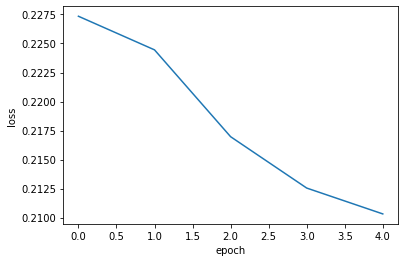

In [13]:
# 손실 그래프
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('7_3-01', dpi=300)
plt.show()

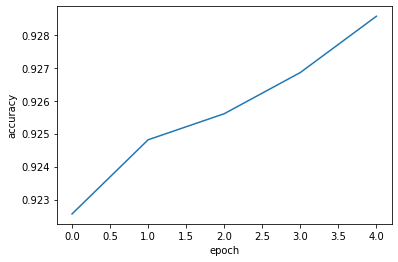

In [14]:
# 정확도 그래프
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('7_3-02', dpi=300)
plt.show()

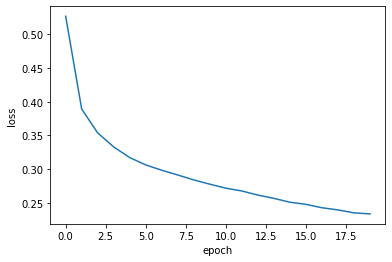

In [15]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

# epoch를 20으로 늘려 훈련
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('7_3-03', dpi=300)
plt.show()

## 검증 손실

In [16]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

# 에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit()에 검증데이터 전달 가능.
# validation_data : 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달.
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

# history.history 딕셔너리에 들어있는 값
print(history.history.keys())
# val_loss : 검증 세트에 대한 손실
# val_accuracy : 정확도

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


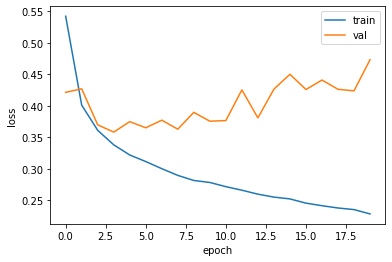

In [17]:
# 과대/과소 적합 문제 보기 위한 손실과 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-04', dpi=300)
plt.show()

# 검증 손실이 감소하다 다섯번째 에포크부터 상승시작. 훈련 손실을 꾸준히 감소하기에 과대적합 모델.
# 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐 아니라 검증 세트에 대한 정확도도 증가할 것임.

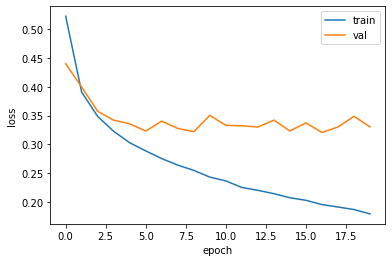

In [18]:
# 옵티마이저 하이퍼파라미터 조정하여 과대 적합 완화 가능.
model = model_fn()
# optimizer='adam' : Adam 옵티마이저 적용
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-05', dpi=300)
plt.show()

# 과대적합 감소.

## 드롭아웃

In [19]:
# 케라스에서는 드롭아웃을 keras.layers 패키지 아래 Dropout 클래스로 제공함.
# 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만드는 것. 드롭아웃이 층처럼 사용되지만 훈련되는 모델 파라미터가 없고 입력과 출력 크기가 같음, 일부 뉴런의 출력을 0으로 만들지만 전체 출력 배열의 크기를 바꾸지는 않음.
# 훈련이 끝난 후 평가나 예측 수행할 때는 드롭아웃을 적용하지 않아야 함. -> 텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃 적용하지 않음.
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


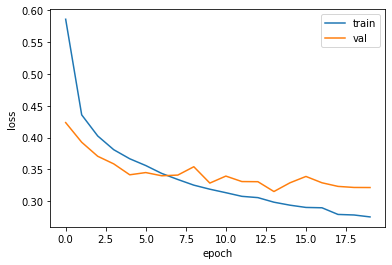

In [20]:
# 훈련 손실과 검증 손실의 그래프
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-06', dpi=300)
plt.show()
# 과대적합 줄었지만 그래도 과소적합 되어 있는 상태

## 모델 저장과 복원

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# 에포크 횟수 10
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

# save_weights : 케라스 모델에서 제공하는 훈련된 모델의 파라미터를 저장하는 메서드
model.save_weights('model-weights.h5')
# save : 모델 구조와 모델 파라미터를 함께 저장하는 메서드
model.save('model-whole.h5')

# 두 파일 잘 만들어졌는지 확인.
!ls -al *.h5

-rw-r--r-- 1 root root 332480 Jul 30 13:21 model-weights.h5
-rw-r--r-- 1 root root 981736 Jul 30 13:21 model-whole.h5


In [23]:
# 훈련 하지 않은 새로운 모델을 만들고 model-weights.h5파일에서 훈련된 모델 파라미터 읽어서 사용.

# 훈련하지 않은 새로운 모델 생성
model = model_fn(keras.layers.Dropout(0.3))
# 이전에 저장했던 모델 파라미터 적제
model.load_weights('model-weights.h5')

# 케라스에서 예측수행하는 predict()는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률 반환.
# 확률 중 가장 큰 값의 인덱스를 골라 타깃 레이블과 비교하여 정확도 계산.
# argmax() : 배열에서 가장 큰 값의 인덱스 반환.
# axis = -1 : 배열의 마지막 차원을 따라 최댓값을 고름.(ex. 검증세트가 2차원 배열이라면 마지막 차원은 1)
# axis = 1 : 열을 따라 각 행의 최댓값 인덱스를 선택.
# axis = 0 : 행을 다라 각 열의 최댓값 인덱스 선택.
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
# 두 배열에서 각 위치의 값이 같으면 1, 다르면 0, 이를 평균하면 정확도
print(np.mean(val_labels == val_target))

# load_model() : 모델이 저장된 파일 읽을 때 사용.
model = keras.models.load_model('model-whole.h5')
# 검증 세트 정확도 출력. 같은 모델 저장하고 불러들였기 때문에 위와 동일한 정확도 얻음.
model.evaluate(val_scaled, val_target)

0.88225
375/375 [==============================] - 1s 2ms/step - loss: 0.3303 - accuracy: 0.8823


[0.33030369877815247, 0.8822500109672546]

## 콜백

In [24]:
# model_fn으로 모델 생성후 compile() 호출.
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# ModelCheckpoint : 이 콜백은 기본적으로 최상의 검증 점수를 만드는 모델 저장. 
# best-model.h5 : 저장된 파일이름.
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3168 - accuracy: 0.8898


[0.3167959451675415, 0.8897500038146973]

In [27]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

# EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,  validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

# early_stopping_cb.stopped_epoch : 훈련 마친 후, 몇번 째 에포크에서 훈련 중지되었는지 확인 가능.
# 결과-1 번째 에포크에서 훈련 중지되었음을 의미.
print(early_stopping_cb.stopped_epoch)

# 조기 종료로 얻은 모델을 사용하여 검증 세트에 대한 성능 확인.
model.evaluate(val_scaled, val_target)


14
375/375 [==============================] - 0s 1ms/step - loss: 0.3204 - accuracy: 0.8847


[0.3204129934310913, 0.8846666812896729]

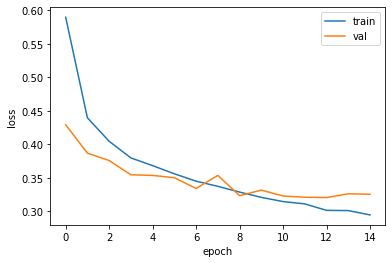

In [28]:
# 훈련 손실과 검증 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-07', dpi=300)
plt.show()